In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sqlite3
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [2]:
def make_circle(r, n, noise = 30, seed = 1234):
    np.random.seed(seed)
    return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-noise,noise), math.sin(2*math.pi/n*x)*r+np.random.normal(-noise,noise)) for x in range(1,n+1)]

small_circle = make_circle(100, 300, 10)
medium_circle = make_circle(300, 700, 20)
big_circle = make_circle(500, 1000, 30)

noise = [(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)]

<Axes: xlabel='x', ylabel='y'>

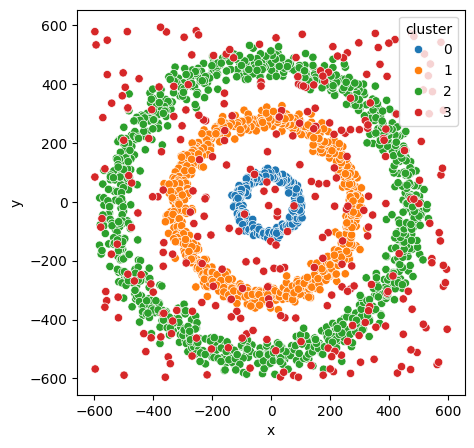

In [3]:
def arrray_to_df(arr, i):
    df = pd.DataFrame(arr)
    df['cluster'] = str(i)
    return df

data = [arrray_to_df(arr, i) for i, arr in enumerate([small_circle, medium_circle, big_circle, noise])]

data = pd.concat(data)
data.columns = ['x', 'y', 'cluster']


plt.rcParams['figure.figsize'] = [5,5]
sns.scatterplot(
data = data, 
x = 'x',
y = 'y',
hue = 'cluster'
)

<Axes: xlabel='x', ylabel='y'>

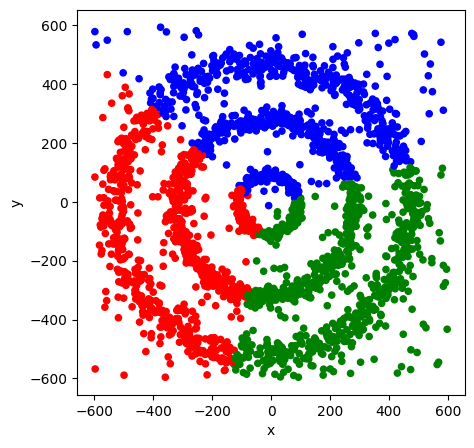

In [4]:
preds = KMeans(n_clusters = 3, random_state =123).fit_predict(data)

cols = { 
0: 'r',
1: 'g',
2: 'b'
}

data['kmeans_pred'] = [cols.get(pred) for pred in preds]
data.plot.scatter('x', 'y', c='kmeans_pred')

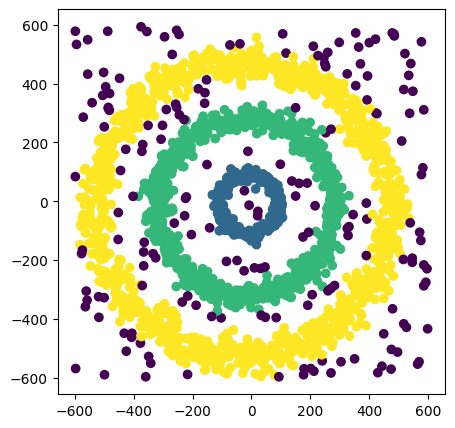

In [5]:
data['dbscan'] = DBSCAN(eps=32, min_samples=5).fit_predict(data[['x', 'y']])

plt.scatter(
    data['x'],
    data['y'],
    c = data['dbscan']
)

In [ ]:
# aruodas


In [11]:
SDB = sqlite3.connect('aruodas3.db')
Cs = SDB.cursor()

sql="""select * from aruododuomenys;"""
df_with_dubs = pd.read_sql_query(sql, con=SDB)
df = df_with_dubs.drop_duplicates()

In [12]:
def set_plotas(x):
    plotas = x.replace(',', '.').split()[0]
    return float(plotas)

df['plotas'] = df['plotas'].apply(set_plotas)

In [13]:
df['kv_kaina'] = round(df['kaina'] / df['plotas'], 2)
df.head(2)

,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas,kv_kaina
0,34.93,2,5,5,2023,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės,4967.08
1,66.64,2,3,5,2003,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai,3076.23


In [27]:
vilnius = df[df['miestas'] == 'Vilnius']
vilnius.dropna(inplace=True)
vilnius.head(2)

,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas,kv_kaina
1,66.64,2,3,5,2003,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai,3076.23
3,98.00,3,2,5,2008,Mūrinis,Centrinis,Įrengtas,A+,54.691637,25.284638,Vilnius,615000,Šnipiškės,6275.51


In [34]:
vilnius_check = vilnius[['ilguma', 'platuma', 'kv_kaina']].dropna()
vilnius_check.head(2)

,ilguma,platuma,kv_kaina
1,54.705467,25.286944,3076.23
3,54.691637,25.284638,6275.51


In [35]:
scaler = StandardScaler()
scaler.fit(vilnius_check[['ilguma','platuma','kv_kaina']])
vilnius_scaled = scaler.transform(vilnius_check[['ilguma','platuma','kv_kaina']])
vilnius_scaled

array([[ 0.22027524,  0.50661632, -0.65396734],
       [-0.28461011,  0.46117222,  1.84039288],
       [ 0.28668063,  0.49276238, -0.56482068],
       ...,
       [ 0.09976718, -0.16960607,  0.43152626],
       [-0.09335238,  0.45776293, -0.61375233],
       [-0.06341702,  0.24465257,  1.1874719 ]])

In [36]:
il_sc, pl_sc, kv_sc = zip(*vilnius_scaled)
vilnius_check['ilguma'] = il_sc
vilnius_check['platuma'] = pl_sc
vilnius_check['kv_kaina'] = kv_sc
vilnius_check.head(2)

,ilguma,platuma,kv_kaina
1,0.220275,0.506616,-0.653967
3,-0.284610,0.461172,1.840393


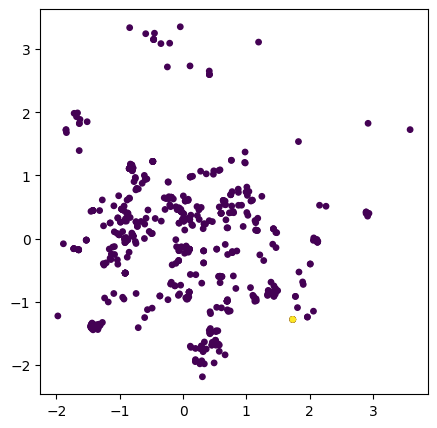

In [45]:
vilnius_check['dbscan'] = DBSCAN(eps=0.01, min_samples=5).fit_predict(vilnius_check[['ilguma', 'platuma', 'kv_kaina']])

plt.scatter(
    vilnius_check['ilguma'],
    vilnius_check['platuma'],
    c = vilnius_check['dbscan'],
    s=15
)

In [ ]:
# paskaičiuokiet sliuete score
# a) pabandykite su gridsearchu rasti optimalius parametrsu,
# ir su jais pritaikykite dbscan savo duomenims

In [47]:
vilnius_check = vilnius[['ilguma', 'platuma']].dropna()
vilnius_check.head(2)

,ilguma,platuma
1,54.705467,25.286944
3,54.691637,25.284638


In [48]:
import plotly.express as px

In [49]:
fig = px.scatter_mapbox(data_frame=vilnius_check, lat='ilguma', lon='platuma', zoom=4)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=800, height=600)
fig.show()

In [55]:
X = vilnius_check.to_numpy() # duomenis, kurios fitinsime su DBSCAN

from sklearn.cluster import DBSCAN

dbm = DBSCAN(eps=0.05, min_samples=5)

predictions = dbm.fit(X) # fitinam koordinantes

vilnius_check['cluster'] = predictions.labels_ # prisidedam naują stulpelį su predicted cluster labels

fig = px.scatter_mapbox(data_frame=vilnius_check, lat='ilguma', lon='platuma', color='cluster', zoom=4)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=800, height=600)
fig.show()

In [56]:
from sklearn.metrics import silhouette_score as shs

shs(X,vilnius_check['cluster']) # surandame Average Silhouette Score

np.float64(0.5845029733501705)

In [57]:
epsilon = np.linspace(0.01, 1, num = 20) # ε vertės
min_samples = np.arange(2,25,step=2) # MinPts vertės

In [58]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'eps':epsilon,
    'min_samples':min_samples
}
dbscn = DBSCAN()
grid_search = GridSearchCV(dbscn, param_grid, scoring='accuracy')
grid_search.fit(X)

best_eps = grid_search.best_params_['eps']
best_min_samples = grid_search.best_params_['min_samples']

print(best_eps, best_min_samples, sep='\n')

0.01
2


In [60]:
dbm = DBSCAN(eps=best_eps,min_samples=best_min_samples) # modifikavom ε ir minPts

predictions = dbm.fit(X) # fitinam koordinantes

vilnius_check['cluster'] = predictions.labels_ # prisidedam naują stulpelį su predicted cluster labels

fig = px.scatter_mapbox(data_frame=vilnius_check, lat='ilguma', lon='platuma', color='cluster', zoom=4)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=800, height=600)
fig.show()

In [61]:
shs(X,vilnius_check['cluster']) # surandame Average Silhouette Score

np.float64(0.15521810569161257)

In [62]:
def GridSearch(combinations, X):
    '''
    Čia combinations - visos galimos epsilon ir minPts kombinacijos, kurias norime tikrinti
    X - data, kurią fitiname
    '''
    scores = [] # čia dėsime shs score
    all_labels = [] # čia dėsime predited labels
    for i, (eps, num_samples) in enumerate(combinations):
        predictions = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = predictions.labels_
        # ir klasterių pavadinimus: (jie gali kartotis, tad pasidarome set'ą - unikalių verčių sąrašą)
        clusters = list(set(labels))
        # randam klasterių kiekį:
        clusters_count = len(clusters)
        if -1 in clusters: # -1 žymimas noise, vadinasi, klasterių yra vienu mažiau, nei unikalių laibelių
            clusters_count = clusters_count - 1                      
        if (clusters_count < 2) and (clusters_count > 25): # jei rado mažiau nei 2 klasterius - blogai, turime dėmę
            # o viršutinė riba 25 - apsiribojame, kad nepridarytų belekiek klasterių, kas rodytų overfitinimą
            scores.append(-20)
            all_labels.append('Poor values')
            print(f'{i:4} iteracija skipinta', end='\r')
            continue
        if len(labels) > 2: # jei labelių bus 1 - silhouette fails, negalima toliau eiti
            try:
                scores.append(shs(X,labels))
                all_labels.append(labels)
                print(f'{i:4} iteracija pridėta', end="\r")
            except Exception as ex:
                print(f'{i:4} iteracija skipinta, klaida {ex}', end='\r')
    best_index = np.argmax(scores)
    best_params = combinations[best_index]
    best_labels = all_labels[best_index]
    best_score = scores[best_index]
    return {'eps':best_params[0], 'minPts':best_params[1],'labels':best_labels, 'score':best_score}


import itertools

combinations = list(itertools.product(epsilon,min_samples))

bp = GridSearch(combinations,X)

In [63]:
for k,v in bp.items():
    print(k,v, sep = '\t')

eps	0.01
minPts	20
labels	[ 0  0  0  1  2  1  0  7  2  0  3  3  0 -1  2 -1  3  4  4  4 -1  4  2  3
  0  4  0  0 -1 -1 -1  0  5 -1  6 -1  4  0  1 -1  3  3  0 -1  0 -1  2 -1
  4  4 -1 -1 -1  4  0  3 -1  7  6 -1  0 -1  2  0  2  5 -1  4  6  0  1  7
  0 -1  4  7  0 -1 -1 -1 -1 -1 -1  0  0  0 -1  7  0  5  3 -1  0  0 -1  1
 -1  2  5  4  5 -1  3  4 -1  6  0  7  4  7  4  0  7  2 -1  7  4 -1  2  2
 -1  4  0  6  1 -1 -1  5 -1  2  3  4  3  4  4  1 -1 -1 -1 -1 -1  1  0 -1
  0  0  5  0 -1  4 -1  0  4 -1  0  4  1  0  0  4 -1  4 -1  3 -1  5 -1  4
  0  0  5  7  0  6  6  2  4  4  0  4  6  1  4  3  6  0  2  0  6 -1  0  6
 -1 -1  6  0  4 -1  0  1  0  2 -1 -1  1  0  2 -1  0 -1 -1 -1 -1  1  4  0
  4  0  7  2 -1 -1  5  0  0  3  5 -1 -1  1 -1 -1  4  4  4  4  2 -1  4  4
  0  6  6  6  6 -1  0 -1  0  4  4 -1 -1  3  0  0  0 -1  4 -1 -1  0  0 -1
  2  2  4 -1  0  2 -1  0 -1 -1  7 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1  0  4
 -1 -1  7  6  6 -1 -1 -1  3 -1  4  0 -1  2  7 -1  2  0 -1  3  4  4  2  4
  0 -1 -1 -1 -1  2 -1 -1 

In [64]:
dbm = DBSCAN(eps=bp['eps'],min_samples=bp['minPts']) # modifikavom ε ir minPts

predictions = dbm.fit(X) # fitinam koordinantes

vilnius_check['cluster'] = predictions.labels_ # prisidedam naują stulpelį su predicted cluster labels

fig = px.scatter_mapbox(data_frame=vilnius_check, lat='ilguma', lon='platuma', color='cluster', zoom=4)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=800, height=600)
fig.show()

In [ ]:
# Suskirstykite eismo įvykius į klasterius (2022 metų)
# (pagal koordinantes, atskirai kiekvienai eismo įvykio rūšiai, su 
# DBSCAN bei KMeans). Darydami KMeans klasterizaciją,
# pasinaudokite elbow grafiku optimaliam klasterių skaičiaus nustatymu
# (Jei pavyksta)
# Patekite vizualizacijas klasterių išsidėstymo su mapbox()
# Pasirinkite vieną eismo įvykių rūšį, ir su GridsearchCV,
# GridSearch klase suraskite optimalų klasterių kiekį
# Tada taip pat pateikite klasterių vizualizacijas.

In [65]:
from LKS94WGS84 import *

In [66]:
df = pd.read_json(path_or_buf='https://data.gov.lt/media/filer_public/5e/b8/5eb89d55-f57a-48ec-b1a2-063692c1b6a7/ei_2022_12_31.json', convert_dates=['dataLaikas'])
df = df[['dataLaikas', 'iskaitinis','dalyviuSkaicius','rusis', 'ilguma','platuma']].dropna(subset=['ilguma','platuma'])

In [67]:
df.head(2)

,dataLaikas,iskaitinis,dalyviuSkaicius,rusis,ilguma,platuma
0,2021-12-31 22:00:00,0,1.0,Kiti eismo įvykiai,6083759.0,491606.0
1,2022-01-01 00:40:00,0,2.0,Susidūrimas,6181902.0,317439.0


In [68]:
LAT, LON = [],[]

for ilguma, platuma in zip(df['ilguma'],df['platuma']):
    lat, lon = grid2geo(platuma, ilguma)
    LAT.append(lat)
    LON.append(lon)

df['long'] = LON
df['lat'] = LAT

df.head(2)

,dataLaikas,iskaitinis,dalyviuSkaicius,rusis,ilguma,platuma,long,lat
0,2021-12-31 22:00:00,0,1.0,Kiti eismo įvykiai,6083759.0,491606.0,23.869164,54.889850
1,2022-01-01 00:40:00,0,2.0,Susidūrimas,6181902.0,317439.0,21.092653,55.737249


In [77]:
top4 = df['rusis'].value_counts().head(4).index
top4

Index(['Susidūrimas', 'Užvažiavimas ant gyvūno',
       'Susidūrimas su stovinčia transporto priemone', 'Kiti eismo įvykiai'],
      dtype='object', name='rusis')

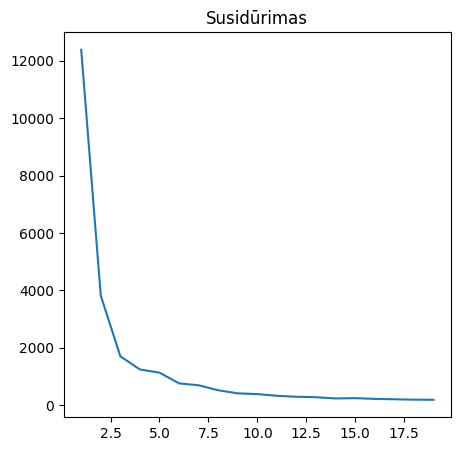

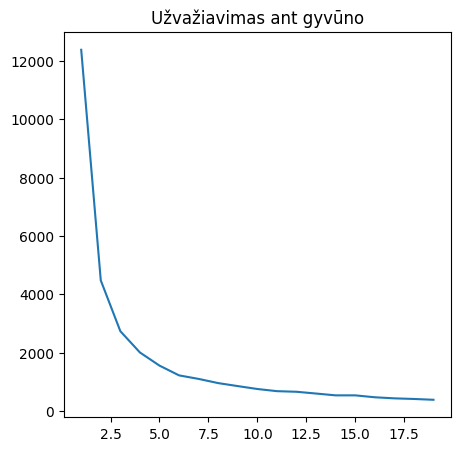

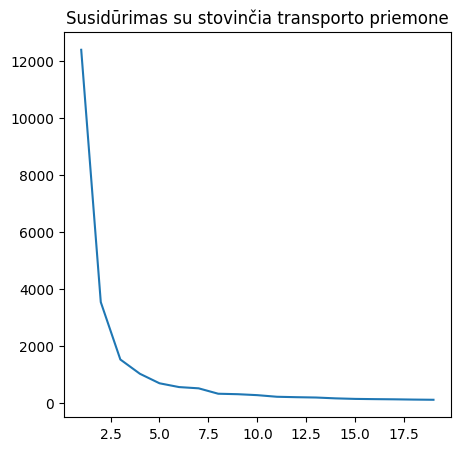

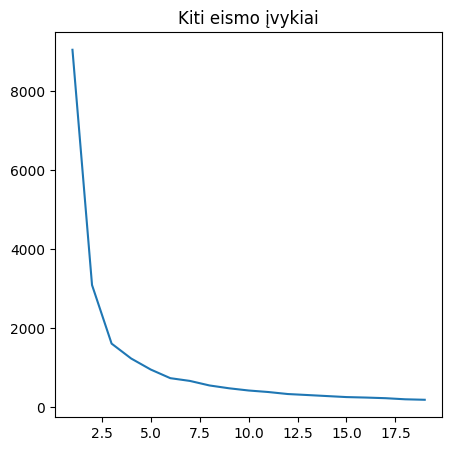

In [84]:
for rusis in top4:
    X = df[df['rusis'] == rusis][['lat', 'long']]
    
    # print(rusis)
    
    sse = []
    for k in range(1, 20):
        km = KMeans(n_clusters=k)
        km.fit(X[['lat', 'long']])
        sse.append(km.inertia_)

    ax = sns.lineplot(x=[*range(1, 20)], y=sse)
    plt.title(rusis)
    plt.show()

In [85]:
print(top4)

Index(['Susidūrimas', 'Užvažiavimas ant gyvūno',
       'Susidūrimas su stovinčia transporto priemone', 'Kiti eismo įvykiai'],
      dtype='object', name='rusis')


In [86]:
clusteriai = {
    'Susidūrimas':7, 
    'Užvažiavimas ant gyvūno':7,
    'Susidūrimas su stovinčia transporto priemone':8, 
    'Kiti eismo įvykiai':7}

In [102]:
for rusis in top4:
    for k, v in clusteriai.items():
        if rusis == k:
            X = df[df['rusis'] == rusis][['lat', 'long']]
            # print(X.columns)
            kmeans = KMeans(n_clusters=v)

            predicted_labels = kmeans.fit_predict(X[['lat', 'long']])
            X['cluster'] = predicted_labels
            
            fig = px.scatter_mapbox(data_frame=X, lat='lat', lon='long', color='cluster', zoom=4)
            fig.update_layout(mapbox_style="open-street-map")
            fig.update_layout(width=800, height=600, title=rusis)
            fig.show()

In [103]:
# vilnius_check['dbscan'] = DBSCAN(eps=0.01, min_samples=5).fit_predict(vilnius_check[['ilguma', 'platuma', 'kv_kaina']])

# plt.scatter(
#     vilnius_check['ilguma'],
#     vilnius_check['platuma'],
#     c = vilnius_check['dbscan'],
#     s=15
# )

for rusis in top4:
    for k, v in clusteriai.items():
        if rusis == k:
            X = df[df['rusis'] == rusis][['lat', 'long']]
            
            X['dbscan'] = DBSCAN(eps=0.15, min_samples=50).fit_predict(X[['lat', 'long']])
            fig = px.scatter_mapbox(data_frame=X[X['dbscan'] != -1], lat='lat', lon='long', color='dbscan', zoom=4)
            fig.update_layout(mapbox_style="open-street-map")
            fig.update_layout(width=800, height=600, title=rusis)
            fig.show()

In [ ]:
# Pasirinkite vieną eismo įvykių rūšį, ir su GridsearchCV,
# GridSearch klase suraskite optimalų klasterių kiekį
# Tada taip pat pateikite klasterių vizualizacijas.

In [98]:
for rusis in top4[:1]:
    for k, v in clusteriai.items():
        if rusis == k:
            X = df[df['rusis'] == rusis][['lat', 'long']]
            print(rusis)
            
X
            


Susidūrimas


,lat,long
1,55.737249,21.092653
23,54.563632,23.354309
26,54.603308,23.192033
50,54.744642,23.662758
51,54.708751,25.285634
...,...,...
23503,54.692030,25.305628
23508,54.647075,23.030240
23509,55.953630,25.589173
23510,55.753061,21.132912


In [99]:
from sklearn.model_selection import GridSearchCV # su gridsearchcv tuninsime parametrus
# Define the parameter grid
param_grid = {
'n_clusters': range(2, 6 + 1),
'init': ['k-means++', 'random'],
'n_init': [5, 10, 15],
'max_iter': [100, 200, 300, 400, 500],
'tol': [0.0001, 0.001, 0.01],
'algorithm': ['auto', 'full', 'elkan', 'lloyd'],
'random_state': [0, 42, 100]
}

# Create the KMeans object
kmeans = KMeans(random_state=42)

# Perform grid search
grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X) # fitinam X, kurį susigeneravom darbo pradžioje

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print('Optimal number of clusters based on parameter grid: ' + str(grid_search.best_params_['n_clusters']))

Best hyperparameters:  {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6, 'n_init': 10, 'random_state': 100, 'tol': 0.001}
Optimal number of clusters based on parameter grid: 6


In [101]:
kmeans = KMeans(algorithm='elkan', init='k-means++', max_iter=100, n_clusters=6, n_init=10, random_state=100, tol=0.001)

predicted_labels = kmeans.fit_predict(X[['lat', 'long']])
X['cluster'] = predicted_labels

fig = px.scatter_mapbox(data_frame=X, lat='lat', lon='long', color='cluster', zoom=4)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=800, height=600, title=rusis)
fig.show()

# ax.grid(True)

# plt.show()